# Dependency Parsing
In this notebook, we perform dependency parsing for the texts in the **LOGIC** dataset

In [1]:
# Install `spacy` package to perform dependency parsing
!pip install spacy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib
from   matplotlib import pyplot as plt
import seaborn as sns

from collections import deque
from copy import deepcopy
import pickle
import json
from tqdm import tqdm
from pprint import pprint
from functools import lru_cache

import spacy
import nltk 

In [3]:
# Setup for plotting
sns.set(style='darkgrid')
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.figsize'] = (10, 5)

In [4]:
# Setup for nltk
nltk.download('punkt') # For tokenizers
nltk.download('stopwords')
nltk.download('wordnet') # For lemmatizers
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

# Setup for spacy
!python -m spacy download en_core_web_sm
scapy_nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /home/utkarsh-am/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/utkarsh-
[nltk_data]     am/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/utkarsh-
[nltk_data]     am/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/utkarsh-
[nltk_data]     am/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


2023-04-11 06:22:04.925382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 06:22:05.802317: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/home/utkarsh-am/opt/openmpi/lib
2023-04-11 06:22:05.802402: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/home/utkarsh-am/opt/openmpi/lib
2023-04-11 0

In [5]:
# For caching objects

def load_obj(file_path):
    """Load a pickled object from given path
    :param file_path: Path to the pickle file of the object
    :type file_path: string
    """
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def save_obj(obj, file_path):
    """Save an object to given path via pickling
    :param obj: Object to pickle
    :param file_path: Path for pickling
    :type file_path: string
    """
    with open(file_path, 'wb') as f:
        return pickle.dump(obj, f)

In [6]:
# Load the LOGIC dataset

train_df = pd.read_csv('./dataset/train.csv')
dev_df   = pd.read_csv('./dataset/dev.csv')
test_df  = pd.read_csv('./dataset/test.csv')

In [7]:
train_texts        = list(train_df['text'])
train_labels       = list(train_df['label'])
train_masked_texts = list(train_df['masked_text'])

dev_texts        = list(dev_df['text'])
dev_labels       = list(dev_df['label'])
dev_masked_texts = list(dev_df['masked_text'])

test_texts        = list(test_df['text'])
test_labels       = list(test_df['label'])
test_masked_texts = list(test_df['masked_text'])

[]

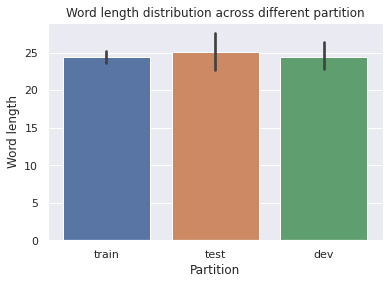

In [8]:
# Get the distribution of sentence length

text_length_dist = {'length': [], 'dataset': []}

for text in train_texts:
    text_length_dist['length'].append(len(text.strip().split()))
    text_length_dist['dataset'].append('train')

for text in test_texts:
    text_length_dist['length'].append(len(text.strip().split()))
    text_length_dist['dataset'].append('test')

for text in dev_texts:
    text_length_dist['length'].append(len(text.strip().split()))
    text_length_dist['dataset'].append('dev')

ax = sns.barplot(data=text_length_dist, x='dataset', y='length')
ax.set_xlabel('Partition')
ax.set_ylabel('Word length')
ax.set_title('Word length distribution across different partition')
ax.plot()

In [9]:
print(f'#train: {len(train_df)}, #test: {len(test_df)}, #dev: {len(dev_df)}')

#train: 1849, #test: 300, #dev: 300


##  Dependency Parsing

In [10]:
# Get empath dictionary

!wget -O empath-dictionary.tsv https://drive.google.com/uc?id=1kH7_FVkIvF0NajMp8E09fssRDb4_h4j6

--2023-04-11 06:22:57--  https://drive.google.com/uc?id=1kH7_FVkIvF0NajMp8E09fssRDb4_h4j6
Resolving drive.google.com (drive.google.com)... 142.250.183.142, 2404:6800:4009:82f::200e
Connecting to drive.google.com (drive.google.com)|142.250.183.142|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-7o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0579mtmufgovbu79jnvjm1cbjvcca331/1681174350000/14292413845157007490/*/1kH7_FVkIvF0NajMp8E09fssRDb4_h4j6?uuid=db72f074-0320-4c74-a838-ca55c022f9a8 [following]
--2023-04-11 06:22:58--  https://doc-0g-7o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0579mtmufgovbu79jnvjm1cbjvcca331/1681174350000/14292413845157007490/*/1kH7_FVkIvF0NajMp8E09fssRDb4_h4j6?uuid=db72f074-0320-4c74-a838-ca55c022f9a8
Resolving doc-0g-7o-docs.googleusercontent.com (doc-0g-7o-docs.googleusercontent.com)... 142.250.199.129, 2404:6800:4009:827::2001
Connecting to doc-0g-7o-do

In [11]:
def load_empath_dictionary():
    """
    Returns a dict[str, list] object where keys are categories and values are 
    associated words for that category
    """
    empath_dict = dict()
    with open('./empath-dictionary.tsv', 'r') as f:
        for line in f:
            cols = line.strip().split("\t")
            name = cols[0]
            terms = cols[1:]
            empath_dict[name] = list()
            for t in set(terms):
                empath_dict[name].append(t)
    return empath_dict

In [12]:
empath_dict = load_empath_dictionary()

In [13]:
tokens_count = list()
for v in empath_dict.values():
    tokens_count.append(len(v))
print(f'Average token count {np.average(tokens_count)}, Std. dev {np.std(tokens_count)}')

Average token count 83.29381443298969, Std. dev 28.771070501829353


In [15]:
# Get Slur words dictionary 

!wget -O slur-word-dictionary.json https://drive.google.com/uc?id=1q_cEj_qlAEDnSpY5_dV-Bl3Nvm74bL9K

--2023-04-11 06:31:00--  https://drive.google.com/uc?id=1q_cEj_qlAEDnSpY5_dV-Bl3Nvm74bL9K
Resolving drive.google.com (drive.google.com)... 142.250.183.142, 2404:6800:4009:830::200e
Connecting to drive.google.com (drive.google.com)|142.250.183.142|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-7o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4gi9phbjrt3d6h06vd2e0rnu8rj7cask/1681174800000/14292413845157007490/*/1q_cEj_qlAEDnSpY5_dV-Bl3Nvm74bL9K?uuid=d45f8aef-c9f0-4cb7-8c33-af898f72f752 [following]
--2023-04-11 06:31:01--  https://doc-10-7o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4gi9phbjrt3d6h06vd2e0rnu8rj7cask/1681174800000/14292413845157007490/*/1q_cEj_qlAEDnSpY5_dV-Bl3Nvm74bL9K?uuid=d45f8aef-c9f0-4cb7-8c33-af898f72f752
Resolving doc-10-7o-docs.googleusercontent.com (doc-10-7o-docs.googleusercontent.com)... 142.250.192.1, 2404:6800:4009:827::2001
Connecting to doc-10-7o-docs

In [16]:
# SOTA slur word dictionary (from Punyajoy)
with open('./slur-word-dictionary.json') as f:
    slur_words_dict = json.load(f)

In [17]:
# Get hate categories

!wget -O hate-categories.json https://drive.google.com/uc?id=1zsuchbPYSoTUfplkw7G6kVW8omLyf8tU

--2023-04-11 06:31:07--  https://drive.google.com/uc?id=1zsuchbPYSoTUfplkw7G6kVW8omLyf8tU
Resolving drive.google.com (drive.google.com)... 142.250.183.142, 2404:6800:4009:830::200e
Connecting to drive.google.com (drive.google.com)|142.250.183.142|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-7o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/41s5o9ud7ifdi6bnl7ockhiqgg4l1o99/1681174800000/14292413845157007490/*/1zsuchbPYSoTUfplkw7G6kVW8omLyf8tU?uuid=d642a2c1-1c75-44ac-90da-424c906feecd [following]
--2023-04-11 06:31:08--  https://doc-0o-7o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/41s5o9ud7ifdi6bnl7ockhiqgg4l1o99/1681174800000/14292413845157007490/*/1zsuchbPYSoTUfplkw7G6kVW8omLyf8tU?uuid=d642a2c1-1c75-44ac-90da-424c906feecd
Resolving doc-0o-7o-docs.googleusercontent.com (doc-0o-7o-docs.googleusercontent.com)... 142.250.192.1, 2404:6800:4009:827::2001
Connecting to doc-0o-7o-docs

In [18]:
# Hate-targets broad categories
# Paper: "A Measurement Study of Hate Speech in Social Media", Mainack Mondal
with open('./hate-categories.json') as f:
    hate_targets_dict = json.load(f)
pprint(hate_targets_dict)

{'Behavior': ['negative_emotion',
              'timidity',
              'disappointment',
              'animal',
              'smell',
              'anger',
              'torment',
              'shame',
              'lust',
              'sadness',
              'rage',
              'dominant_personality',
              'violence',
              'childish',
              'pet',
              'irritability',
              'fear',
              'sexual',
              'ridicule',
              'wealthy',
              'weakness',
              'nervousness',
              'envy',
              'aggression',
              'hate'],
 'Class': ['economy', 'poor', 'stealing'],
 'Crime': ['prison', 'crime', 'terrorism'],
 'Disablity': ['mental'],
 'Ethnicity': ['immigrant', 'arabs', 'asians'],
 'Gender': ['women', 'feminine'],
 'Physical': ['monster',
              'ugliness',
              'youth',
              'appearance',
              'disgust',
              'hygiene',
        

In [19]:
hate_targets_raw = dict()
# key: hate_targets
# value: list of raw tokens associated with that target

for k, v in hate_targets_dict.items():
    hate_targets_raw[k] = list()
    for token_type in v:
        if token_type in slur_words_dict:
            hate_targets_raw[k].extend(slur_words_dict[token_type])
        if token_type in empath_dict:
            hate_targets_raw[k].extend(empath_dict[token_type])

In [20]:
lemmatizer = WordNetLemmatizer()
replace_underscores_with_whitespaces = lambda z: ' '.join(z.split('_'))

hate_targets = dict()
# key: hate_targets
# value: list of processed tokens associated with that target

for k, v in hate_targets_raw.items():
    temp = list(map(lemmatizer.lemmatize, v))
    hate_targets[k] = set(map(replace_underscores_with_whitespaces, temp))

# pprint(hate_targets)

In [21]:
def create_dependency_graph(doc):
    """Create dependency graph of tokens from scapy doc
    :param doc: scapy doc instance
    """
    dependency_edges = list() # (parent, child, relationship)
    id_to_text = dict()
    id_to_token = dict()
    root = None
    node_count = 0

    for token in doc:
        node_count += 1
        parent = token.head.i
        child = token.i
        relationship = token.dep_
        id_to_text[child] = lemmatizer.lemmatize(token.text)
        id_to_token[child] = token
        if relationship == 'ROOT':
            root = child
            continue
        dependency_edges.append((parent, child, relationship))

    dependency_graph = dict()
    for i in range(node_count): 
        dependency_graph[i] = list()
    for p, c, r in dependency_edges:
        dependency_graph[p].append((c, r, 0))
        dependency_graph[c].append((p, r, 1))
    
    return dependency_graph, id_to_text, id_to_token, root

In [22]:
def get_noun_ids(id_to_token):
    """Index generator for nouns / personal nouns / pronouns"""
    for k, v in id_to_token.items():
        if v.pos_ == "NOUN" or v.pos_ == "PROPN" or v.pos_=="PRON":
            yield k

In [23]:
def get_personal_pronoun_ids(id_to_token):
    """Index generator for personal pronouns"""
    for k, v in id_to_token.items():
        if v.tag_ == 'PRP': # Personal pronoun tag in scapy
            yield k

In [24]:
def get_pronoun_ids(id_to_token):
    """Index generator for pronouns"""
    for k, v in id_to_token.items():
        if v.pos_ == 'PRON': # Pronoun tag in scapy
            yield k

In [25]:
def get_trigger_ids(id_to_text, trigger_type):
    """Generates ids which are indices of triggers
    :param id_to_text: id_to_text returned by create_dependency_graph
    :type id_to_text: dict
    :param trigger_type: What type of triggers?
    :type trigger_type: str
    """
    for k, v in id_to_text.items():
        if v in hate_targets[trigger_type]:
            yield k

In [26]:
def breadth_first_search(dependency_graph, source):
    """Performs breadth first search
    :param dependency_graph: Dependency graph returned by create_dependency_graph
    :type dependency_graph: dict
    :param source: Source node ID
    :type source: int
    """
    q = deque()
    used = set()
    d = dict() # distance of nodes from source
    p = dict() # parent in bfs
    r = dict() # relation observed

    q.append(source)
    used.add(source)
    p[source] = -1
    d[source] = 0

    while len(q):
        v = q.popleft()
        for u, rel, orient in dependency_graph[v]:
            if u in used:
                continue
            used.add(u)
            q.append(u)
            d[u] = d[v] + 1
            p[u] = v
            r[u] = (rel, orient)

    return d, p, r

In [27]:
def generate_path_from_bfs(source, dest, dist_dict, parent_dict, relation_dict):
    """Generate path from source to dest. Path will contain relationships 
    encountered in bfs.
    """
    assert dist_dict[source] == 0
    assert dest in dist_dict 

    indices_list = list()     # to store indices along the path

    orientation_list = list() # store whether the edge is traversed
                              # from parent to child
                              # or child to parent
    path = list()
    cur = dest
    while cur != source:
        rel, orient = relation_dict[cur]
        path.append(rel)
        indices_list.append(cur)
        orientation_list.append(orient)
        cur = parent_dict[cur]
    indices_list.append(cur)

    return path, indices_list, orientation_list

In [33]:
def dependency_parsing(texts, index_generator, n_process=8, batch_size=1000):
    """Perform dependency parsing

    :param texts: list of comment body (text)
    :param index_generator: `get_personal_pronoun_ids` or `get_pronoun_ids`
    :param n_process: No. of processes spawned for processing, refer to pipe utility in spacy
    :param batch_size: Batch size while processing, refer to pipe utility in spacy
    """

    result = list()
    # `result` will contain [comment_text, [(path, word_list, word_indices, orientation_list), ...]]

    docs = scapy_nlp.pipe(texts, n_process=n_process, batch_size=batch_size)

    for doc in tqdm(docs, total=len(texts)):
        # Parse comment text and create dependency graph
        local_result = list()
        parsed_result = list()

        local_result.append(doc.text)
        dependency_graph, id_to_text, id_to_token, root \
                                             = create_dependency_graph(doc)

        # Extract the indices using iterator
        for index in index_generator(id_to_token):
            dist, parent, relation = breadth_first_search(dependency_graph,
                                                          index)
            for target_id, target_dist in dist.items():
                if target_dist < 2:
                    # Ignore dependency paths having length less than 2
                    continue

                path, word_indices, orientation = \
                    generate_path_from_bfs(index, target_id, dist,
                                            parent, relation)
                if 'punct' in path:
                    # Ignore dependency paths related to punctuation marks
                    continue

                words = list()
                for word_index in word_indices:
                    words.append(id_to_text[word_index])

                parsed_result.append((tuple(path), tuple(words), tuple(word_indices), tuple(orientation)))

        local_result.append(tuple(parsed_result))
        result.append(tuple(local_result))
    
    return result

In [34]:
train_texts_lc = [s.lower() for s in train_texts]
test_texts_lc  = [s.lower() for s in test_texts]
dev_texts_lc   = [s.lower() for s in dev_texts]

In [35]:
train_texts_parsed = dependency_parsing(train_texts_lc, get_noun_ids)
test_texts_parsed  = dependency_parsing(test_texts_lc,  get_noun_ids)
dev_texts_parsed   = dependency_parsing(dev_texts_lc,   get_noun_ids)

100%|██████████| 300/300 [00:01<00:00, 219.96it/s]


In [38]:
dependency_parsing_results = (train_texts_parsed, test_texts_parsed, dev_texts_parsed)

save_obj(dependency_parsing_results, './dataset/dependency_parsing_results.pkl')